In [1]:
""" Importing libraries """
from ovito.io import *
from ovito.modifiers import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
""" Generic function to determine the solid/liquid interface """
def get_sl_interface(cl, cs) :
    clz_min = np.min(cl[:,2])
    csz_max = np.max(cs[:,2])
    return 0.5*(clz_min+csz_max)

In [3]:
""" Generic function to determine the liquid/vapour interface locations """
def get_lv_interface(bins, target_dens) :
    r_int = 0
    for i in range(len(bins)) :
        if bins[i]>target_dens and bins[i+1]<=target_dens :
            r_int = ((i+1)*hr*(bins[i]-target_dens)+i*hr*(target_dens-bins[i+1]))/(bins[i]-bins[i+1])
            break
    return r_int

In [4]:
""" Define binning variables """
# Vertical bins
Nz = 2
hz = 4 # [Å]
# Radial bins
r0 = 10 # [Å]
Nr = 20
hr = 4 # [Å]
# Angular bins
# (not used at the moment, could be used to 
# compute the std from the CA of each slice)
Nt = 30
ht = 2*np.pi/Nt # [rad]

In [5]:
""" Simulation timestep """
dt = 0.001 # [ps]

In [6]:
""" Define arrays """
r_bins = np.linspace(r0+0.5*hr,r0+hr*(Nr-1)+0.5*hr,Nr)

In [7]:
""" Volume of each grid bin """
# This can be computed beforehand since the bin size 
# is not changing, only the grid center is
bin_vol = np.pi*hz*(np.linspace(r0+hr,r0+hr*Nr,Nr)**2-np.linspace(r0,r0+hr*(Nr-1),Nr)**2)

In [8]:
""" Loading input file into an Ovito pipeline """
pipeline_wetting = import_file("wetting.dump")

In [9]:
""" Append modifiers to the pipeline (e.g. CNA, RDF, ...) """
pipeline_wetting.modifiers.append(CommonNeighborAnalysisModifier())
pipeline_wetting.modifiers.append(CoordinationAnalysisModifier(cutoff=10.0,partial=True))

In [10]:
""" Loop over simulation frames and do something """
n_frame = 0
contact_angle = []
time = []
for data in pipeline_wetting.frames :
    
    time.append(dt*data.attributes['Timestep'])
    
    n_frame += 1
    print('frame # ',n_frame,'/',pipeline_wetting.num_frames)
    
    # Initializing the grid of bins
    bin_grid = np.zeros((Nr,Nz))
    ref_dens = np.zeros(Nz)
    r_int = np.zeros(Nz)
    
    coord_liq = data.particles.positions[data.particles['v_dummymol'] == 1]
    coord_liq = coord_liq[...]
    
    coord_sub = data.particles.positions[data.particles['v_dummymol'] == 2]
    coord_sub = coord_sub[...]
    
    # Determine the SL interface
    z_sl_int = get_sl_interface(coord_liq,coord_sub)
    z_upper = z_sl_int+Nz*hz
    
    # Coordinates of particles in the range of the vertical grid
    coord_near_wall = coord_liq[coord_liq[:,2]>z_sl_int]
    coord_near_wall = coord_near_wall[coord_near_wall[:,2]<=z_upper]
    
    xmean_liq = np.mean(coord_near_wall[:,0])
    ymean_liq = np.mean(coord_near_wall[:,1])
    
    # Coordinates relative to the central axis
    x_liq_rel = coord_near_wall[:,0]-xmean_liq
    y_liq_rel = coord_near_wall[:,1]-ymean_liq
    r_liq = np.sqrt((x_liq_rel**2)+(y_liq_rel**2))
    z_liq = coord_near_wall[:,2]
    
    # Exclude particles near the pole
    r_liq_nopole = r_liq[r_liq>r0]
    z_liq_nopole = z_liq[r_liq>r0]
    
    # Compute reference number density
    z_liq_pole = z_liq[r_liq<=r0]
    jz = ((z_liq_pole-z_sl_int)//hz).astype(int)
    for n in range(len(z_liq_pole)) :
        ref_dens[jz[n]] += 1
    ref_dens /= (np.pi*hz*r0**2)
        
    # Binning
    ir = ((r_liq_nopole-r0)//hr).astype(int)
    jz = ((z_liq_nopole-z_sl_int)//hz).astype(int)
    for n in range(len(r_liq_nopole)) :
        bin_grid[ir[n],jz[n]] += 1
    bin_grid /= bin_vol[:,None]
    
    # Find the radial coordinate of the interface
    for j in range(Nz) :
        r_int[j] = get_lv_interface(bin_grid[:,j],0.5*ref_dens[j])
        r_int[j] += (r0+0.5*hr)
    
    # Extract the contact angle from interface position
    # SIMPLIFIED CASE: ONLY TWO POINTS
    dr = r_int[0]-r_int[1]
    dz = hz
    ca = 0.5*(dr==0)*np.pi+(dr>0)*np.arctan(dz/dr)+(dr<0)*(0.5*np.pi-np.arctan(dz/dr))
    contact_angle.append(np.rad2deg(ca))

frame #  1 / 21
frame #  2 / 21
frame #  3 / 21
frame #  4 / 21
frame #  5 / 21
frame #  6 / 21
frame #  7 / 21
frame #  8 / 21
frame #  9 / 21
frame #  10 / 21
frame #  11 / 21
frame #  12 / 21
frame #  13 / 21
frame #  14 / 21
frame #  15 / 21
frame #  16 / 21
frame #  17 / 21
frame #  18 / 21
frame #  19 / 21
frame #  20 / 21
frame #  21 / 21


## Plotting results

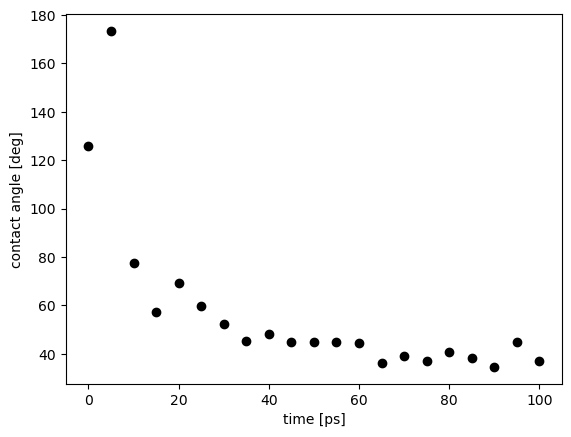

In [11]:
%matplotlib inline
plt.plot(time,contact_angle,'ko')
plt.xlabel("time [ps]")
plt.ylabel("contact angle [deg]")
plt.show()

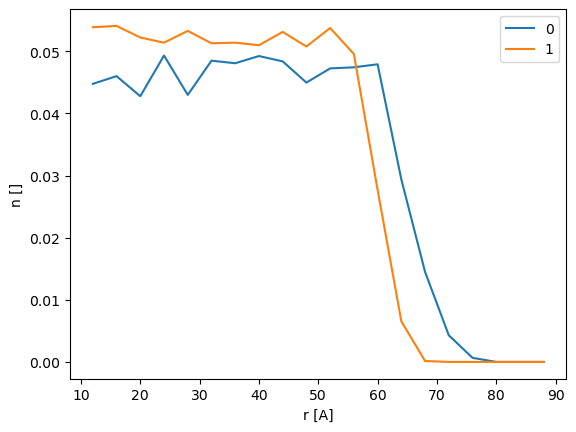

In [12]:
%matplotlib inline
for j in range(Nz) :
    plt.plot(r_bins,bin_grid[:,j],label=str(j))
plt.legend()
plt.xlabel('r [A]')
plt.ylabel('n []')
plt.show()

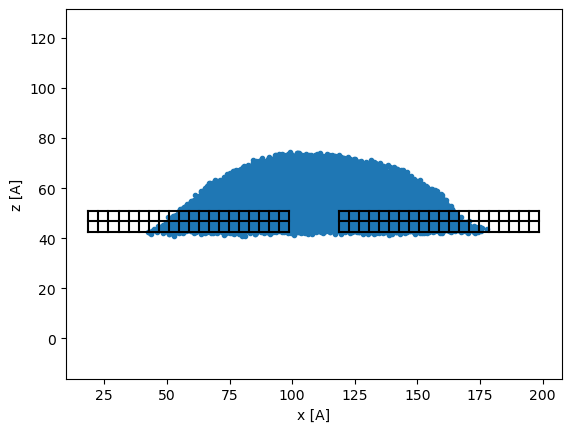

In [13]:
""" Example: 2D scatterplot (xz) of the last fame and SL interface """
%matplotlib inline
fig, ax1 = plt.subplots(1)
ax1.scatter(coord_liq[:,0],coord_liq[:,2],marker='.')
ax1.plot([xmean_liq+r0,xmean_liq+Nr*hr+r0],[z_sl_int,z_sl_int],'k-')
ax1.plot([xmean_liq+r0,xmean_liq+Nr*hr+r0],[z_sl_int+hz,z_sl_int+hz],'k-')
ax1.plot([xmean_liq+r0,xmean_liq+Nr*hr+r0],[z_sl_int+2*hz,z_sl_int+2*hz],'k-')
ax1.plot([xmean_liq-Nr*hr-r0,xmean_liq-r0],[z_sl_int,z_sl_int],'k-')
ax1.plot([xmean_liq-Nr*hr-r0,xmean_liq-r0],[z_sl_int+hz,z_sl_int+hz],'k-')
ax1.plot([xmean_liq-Nr*hr-r0,xmean_liq-r0],[z_sl_int+2*hz,z_sl_int+2*hz],'k-')
for i in range(Nr+1) :
    ax1.plot([xmean_liq+i*hr+r0,xmean_liq+i*hr+r0],[z_sl_int,z_sl_int+2*hz],'k-')
    ax1.plot([xmean_liq-i*hr-r0,xmean_liq-i*hr-r0],[z_sl_int,z_sl_int+2*hz],'k-')
ax1.axis('equal')
ax1.set_xlabel('x [A]')
ax1.set_ylabel('z [A]')
plt.show()

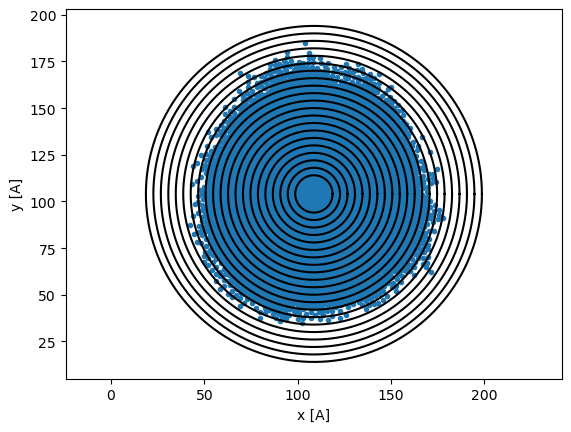

In [14]:
""" Example: 2D scatterplot (xy) of the last fame and radial bins """
%matplotlib inline
fig, ax1 = plt.subplots(1)
ax1.scatter(coord_liq[:,0],coord_liq[:,1],marker='.')
# for i in range(Nt) :
#     rx = xmean_liq+Nr*hr*np.cos(i*ht)*np.linspace(0,1,10)+r0*np.cos(i*ht)
#     ry = ymean_liq+Nr*hr*np.sin(i*ht)*np.linspace(0,1,10)+r0*np.sin(i*ht)
#     ax1.plot(rx,ry,'k-')
for i in range(Nr+1) :
    ax1.plot(xmean_liq+(r0+i*hr)*np.cos(np.linspace(0,2*np.pi,500)),
        ymean_liq+(r0+i*hr)*np.sin(np.linspace(0,2*np.pi,500)),'k-')
ax1.axis('equal')
ax1.set_xlabel('x [A]')
ax1.set_ylabel('y [A]')
plt.show()

In [15]:
""" Example: plot the Al-Al RDF of the last frame """
# rdf_table = pipeline_wetting.compute().tables['coordination-rdf']
# print('Combination of atom types: ',rdf_table.y.component_names)
# rdf_y = rdf_table.y[:,0]
# rdf_x = rdf_table.xy()[...][:,0]
# %matplotlib inline
# plt.plot(rdf_x,rdf_y)

' Example: plot the Al-Al RDF of the last frame '

In [16]:
""" Example: 3D scatterplot of the last fame """
# %matplotlib notebook
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(coord_sub[:,0],coord_sub[:,1],coord_sub[:,2],marker='.')
# ax.scatter(coord_liq[:,0],coord_liq[:,1],coord_liq[:,2],marker='.')
# plt.axis('equal')
# plt.show()

' Example: 3D scatterplot of the last fame '